In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import tensorflow as tf 

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [2]:
os.chdir('E:\\datas')

In [3]:
BASE_DATA_DIR = "E:\\datas\\brain_tumor_dataset" 
categories = ["no", "yes"]

IMG_SIZE_INITIAL = 150 
data = []

In [4]:
for category in categories:
    path = os.path.join(BASE_DATA_DIR, category) 
    label = categories.index(category)
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        try:
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if img is None:
                print(f"Skipping unreadable file: {img_path}")
                continue
            img = cv2.resize(img, (IMG_SIZE_INITIAL, IMG_SIZE_INITIAL)) 
            data.append([img, label])
        except Exception as e:
            print(f"Error loading {img_name}: {e}")

In [5]:
np.random.shuffle(data)

X = np.array([i[0] for i in data]) / 255.0 
y = np.array([i[1] for i in data])

print("Dataset ready: ", X.shape, y.shape)

Dataset ready:  (253, 150, 150, 3) (253,)


In [7]:
X_train_custom_cnn, X_test_custom_cnn, y_train_custom_cnn, y_test_custom_cnn = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [8]:
yes_dir = os.path.join(BASE_DATA_DIR, 'yes') 
no_dir = os.path.join(BASE_DATA_DIR, 'no')   

yes_len = len(os.listdir(yes_dir))
no_len = len(os.listdir(no_dir))

print("yes_count:", yes_len, "| no_count:", no_len)

yes_count: 155 | no_count: 98


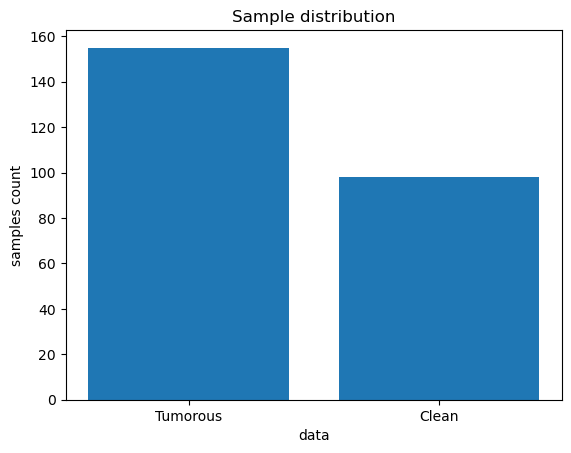

In [9]:
plt.bar(["Tumorous" , "Clean"] , [yes_len , no_len])
plt.xlabel("data")
plt.ylabel("samples count")
plt.title("Sample distribution")
plt.show()

In [10]:
original_yes_dir = os.path.join(BASE_DATA_DIR, 'yes')
original_no_dir = os.path.join(BASE_DATA_DIR, 'no')

def load_images_from_folder(folder, count):
    images = []
    for i, filename in enumerate(os.listdir(folder)):
        if i >= count:
            break
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR) 
        if img is not None:
            images.append(img)
    return images

def augmented_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        brightness_range=(0.3, 1.0),
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )
    for filename in os.listdir(file_dir):
        image = cv2.imread(os.path.join(file_dir, filename))
        if image is None:
            print(f"Skipping unreadable file for augmentation: {os.path.join(file_dir, filename)}")
            continue

        image = image.reshape((1, ) + image.shape)
        save_prefix = 'aug_' + filename.split('.')[0]
        i = 0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,
                                   save_prefix=save_prefix, save_format='jpg'):
            i += 1
            if i >= n_generated_samples:
                break

In [11]:
import time
start_time = time.time()

def timing(seconds):
    mins, secs = divmod(seconds, 60)
    return f"{int(mins)}m {secs:.2f}s"

original_yes_path = os.path.join(BASE_DATA_DIR, 'yes')
original_no_path = os.path.join(BASE_DATA_DIR, 'no')

AUGMENTED_DATA_ROOT = os.path.join(os.getcwd(), 'augmented_dataset_for_vgg')

augmented_yes_dir = os.path.join(AUGMENTED_DATA_ROOT, 'yes')
augmented_no_dir = os.path.join(AUGMENTED_DATA_ROOT, 'no')

os.makedirs(augmented_yes_dir, exist_ok=True)
os.makedirs(augmented_no_dir, exist_ok=True)

for filename in os.listdir(original_yes_path):
    import shutil
    shutil.copy(os.path.join(original_yes_path, filename), augmented_yes_dir)
for filename in os.listdir(original_no_path):
    import shutil
    shutil.copy(os.path.join(original_no_path, filename), augmented_no_dir)

print("Starting data augmentation...")
augmented_data(file_dir=original_yes_path, n_generated_samples=6, save_to_dir=augmented_yes_dir)
augmented_data(file_dir=original_no_path, n_generated_samples=9, save_to_dir=augmented_no_dir)
print("Data augmentation complete.")

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time for augmentation: {timing(execution_time)}")

def data_summary(main_path):
    yes_path_summary = os.path.join(main_path, 'yes')
    no_path_summary = os.path.join(main_path, 'no') 

    n_pos = len(os.listdir(yes_path_summary))
    n_neg = len(os.listdir(no_path_summary))
    n = n_pos + n_neg

    pos_per = (n_pos * 100) / n
    neg_per = (n_neg * 100) / n

    print(f"\nSummary of Augmented Dataset at {main_path}:")
    print(f"Total number of samples: {n}")
    print(f"Positive samples (yes): {n_pos}, ({pos_per:.2f}%)")
    print(f"Negative samples (no): {n_neg}, ({neg_per:.2f}%)")

data_summary(AUGMENTED_DATA_ROOT)

Starting data augmentation...
Data augmentation complete.
Elapsed time for augmentation: 1m 55.20s

Summary of Augmented Dataset at E:\datas\augmented_dataset_for_vgg:
Total number of samples: 2064
Positive samples (yes): 1084, (52.52%)
Negative samples (no): 980, (47.48%)


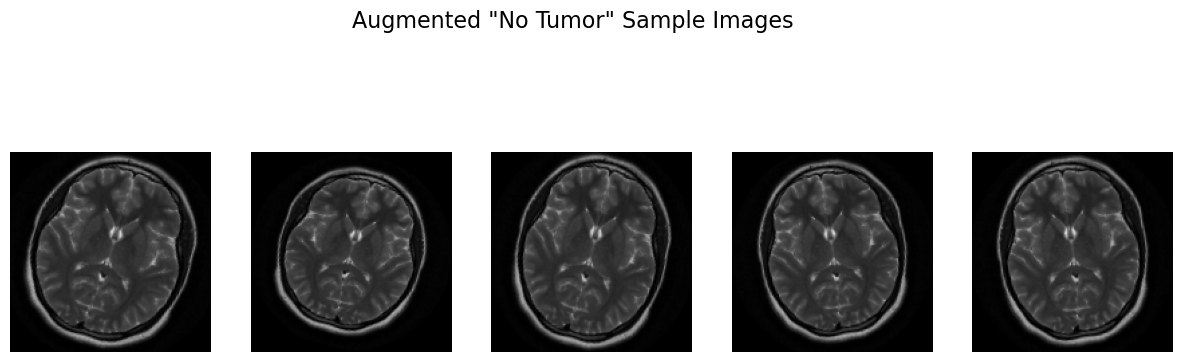

In [12]:
sample_no_tumor_images = load_images_from_folder(original_no_dir, count=1) 

if not sample_no_tumor_images:
    print("Could not load any 'no tumor' images for visualization.")
else:
    datagen_viz = ImageDataGenerator(rotation_range=20, zoom_range=0.15, horizontal_flip=True, fill_mode='nearest')
  
    img_for_viz = sample_no_tumor_images[0]

    img_for_viz = cv2.resize(img_for_viz, (IMG_SIZE_INITIAL, IMG_SIZE_INITIAL))
    if img_for_viz.ndim == 2: 
        img_for_viz = cv2.cvtColor(img_for_viz, cv2.COLOR_GRAY2RGB)
    img_for_viz = img_for_viz.astype('float32') / 255.0

    img_for_viz = img_for_viz.reshape((1, IMG_SIZE_INITIAL, IMG_SIZE_INITIAL, 3))

    aug_iter_viz = datagen_viz.flow(img_for_viz, batch_size=1)

    fig, axs = plt.subplots(1, 5, figsize=(15, 5))
    fig.suptitle('Augmented "No Tumor" Sample Images', fontsize=16)
    for i in range(5):
        batch = next(aug_iter_viz)
        axs[i].imshow(batch[0].reshape(IMG_SIZE_INITIAL, IMG_SIZE_INITIAL, 3))
        axs[i].axis('off')
    plt.show()

In [13]:
custom_cnn_model = Sequential()

custom_cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=X_train_custom_cnn.shape[1:]))
custom_cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

custom_cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
custom_cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

custom_cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
custom_cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

custom_cnn_model.add(Flatten())
custom_cnn_model.add(Dense(128, activation='relu'))
custom_cnn_model.add(Dropout(0.5))
custom_cnn_model.add(Dense(1, activation='sigmoid'))

C:\Users\1\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
custom_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
VGG_IMG_SIZE = 224 
BATCH_SIZE = 32

data_dir_for_vgg = AUGMENTED_DATA_ROOT 

train_datagen_vgg = ImageDataGenerator(
    rescale=1./255,              
    validation_split=0.2,        
    rotation_range=20,           
    width_shift_range=0.1,       
    height_shift_range=0.1,      
    shear_range=0.2,             
    zoom_range=0.2,              
    horizontal_flip=True,        
    vertical_flip=True,          
    fill_mode='nearest'          
)

train_generator_vgg = train_datagen_vgg.flow_from_directory(
    data_dir_for_vgg,
    target_size=(VGG_IMG_SIZE, VGG_IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='binary',
    subset='training',
    shuffle=True
)

validation_generator_vgg = train_datagen_vgg.flow_from_directory(
    data_dir_for_vgg,
    target_size=(VGG_IMG_SIZE, VGG_IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='binary',
    subset='validation',
    shuffle=False 
)

Found 1652 images belonging to 2 classes.
Found 412 images belonging to 2 classes.


In [17]:
input_tensor = Input(shape=(VGG_IMG_SIZE, VGG_IMG_SIZE, 3))

base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

vgg_model = Model(inputs=base_model.input, outputs=predictions)

vgg_model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("VGG16 Model Summary (with frozen base layers):")
vgg_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step 
VGG16 Model Summary (with frozen base layers):


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [18]:
EPOCHS = 20 
label_map = train_generator_vgg.class_indices
no_idx = label_map['no']
yes_idx = label_map['yes']

total_samples = train_generator_vgg.samples
no_samples = len(os.listdir(os.path.join(data_dir_for_vgg, 'no'))) 
yes_samples = len(os.listdir(os.path.join(data_dir_for_vgg, 'yes'))) 

from sklearn.utils import class_weight
class_weights_array = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator_vgg.classes),
    y=train_generator_vgg.classes
)
class_weights = {i: weight for i, weight in enumerate(class_weights_array)}

print("Class Weights:", class_weights)

history_vgg = vgg_model.fit(
    train_generator_vgg,
    validation_data=validation_generator_vgg,
    epochs=EPOCHS,
    class_weight=class_weights,
    steps_per_epoch=train_generator_vgg.samples // BATCH_SIZE, 
    validation_steps=validation_generator_vgg.samples // BATCH_SIZE 
)

train_acc_vgg = history_vgg.history['accuracy'][-1]
val_acc_vgg = history_vgg.history['val_accuracy'][-1]

Class Weights: {0: np.float64(1.0535714285714286), 1: np.float64(0.9516129032258065)}


C:\Users\1\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 212s 4s/step - accuracy: 0.6537 - loss: 0.6528 - val_accuracy: 0.7422 - val_loss: 0.4807
Epoch 2/20
 1/51 ━━━━━━━━━━━━━━━━━━━━ 3:33 4s/step - accuracy: 0.8438 - loss: 0.4058

C:\Users\1\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


51/51 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8438 - loss: 0.4058 - val_accuracy: 0.7734 - val_loss: 0.4807
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 239s 5s/step - accuracy: 0.7636 - loss: 0.4820 - val_accuracy: 0.8203 - val_loss: 0.3988
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 44s 819ms/step - accuracy: 0.8750 - loss: 0.3889 - val_accuracy: 0.8151 - val_loss: 0.4038
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 258s 5s/step - accuracy: 0.7963 - loss: 0.4360 - val_accuracy: 0.8125 - val_loss: 0.4061
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 938ms/step - accuracy: 0.7500 - loss: 0.4346 - val_accuracy: 0.8229 - val_loss: 0.3715
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 246s 5s/step - accuracy: 0.8222 - loss: 0.3828 - val_accuracy: 0.8542 - val_loss: 0.3360
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 50s 924ms/step - accuracy: 0.9062 - loss: 0.2204 - val_accuracy: 0.8411 - val_loss: 0.3461
Epoch 9/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 247s 5s/step - accuracy: 0.8468 - loss: 0.3505 - val_accuracy: 0.8281 - val_los

In [19]:
print(f"Final Training Accuracy (VGG16): {train_acc_vgg * 100:.2f}%")
print(f"Final Validation Accuracy (VGG16): {val_acc_vgg * 100:.2f}%")

Final Training Accuracy (VGG16): 90.62%
Final Validation Accuracy (VGG16): 85.68%


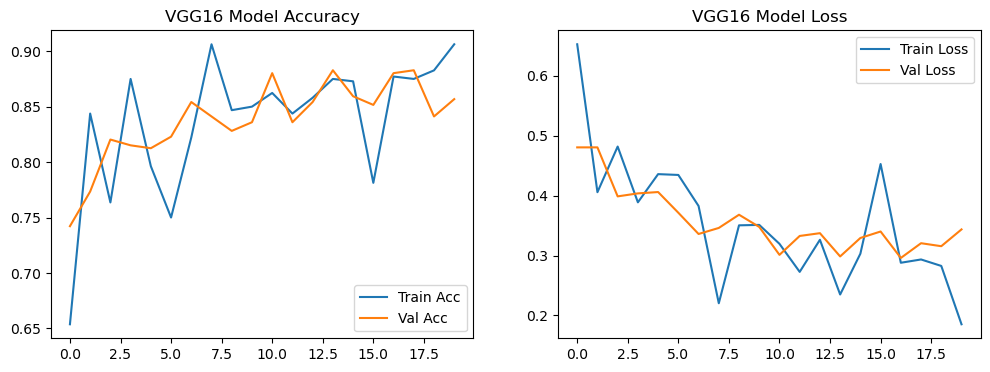

In [20]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_vgg.history['accuracy'], label='Train Acc')
plt.plot(history_vgg.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('VGG16 Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history_vgg.history['loss'], label='Train Loss')
plt.plot(history_vgg.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('VGG16 Model Loss')
plt.show()


--- Model Evaluation ---
13/13 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step


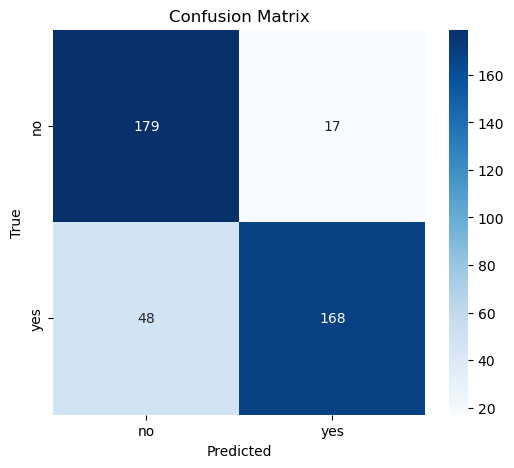


Classification Report:
              precision    recall  f1-score   support

          no       0.79      0.91      0.85       196
         yes       0.91      0.78      0.84       216

    accuracy                           0.84       412
   macro avg       0.85      0.85      0.84       412
weighted avg       0.85      0.84      0.84       412



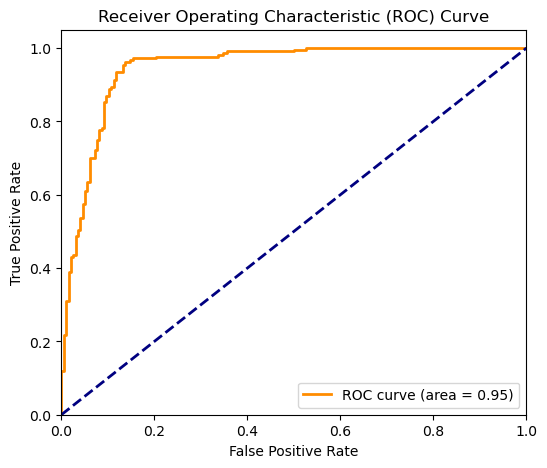


Model saved to brain_tumor_detection_vgg16.h5


In [21]:
print("\n--- Model Evaluation ---")

val_predictions = vgg_model.predict(validation_generator_vgg)
val_labels = validation_generator_vgg.classes

val_pred_binary = (val_predictions > 0.5).astype(int)

cm = confusion_matrix(val_labels, val_pred_binary)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(val_labels, val_pred_binary, target_names=categories))

fpr, tpr, thresholds = roc_curve(val_labels, val_predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

model_save_path = 'brain_tumor_detection_vgg16.h5'
vgg_model.save(model_save_path)
print(f"\nModel saved to {model_save_path}")

# --- Fine-tuning (Optional, advanced step) ---
# After initial training, you can unfreeze some layers of the base model and fine-tune
# for example, unfreeze the last few convolutional blocks
# vgg_model.trainable = True # Unfreeze all layers first
# for layer in vgg_model.layers[:-10]: # Freeze all but the last 10 layers (example)
#     layer.trainable = False

# vgg_model.compile(optimizer=Adam(learning_rate=1e-5), # Use a very small learning rate for fine-tuning
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# print("\nFine-tuning VGG16 Model Summary (with some base layers trainable):")
# vgg_model.summary()

# history_finetune = vgg_model.fit(
#     train_generator_vgg,
#     validation_data=validation_generator_vgg,
#     epochs=EPOCHS, # Or more epochs for fine-tuning
#     class_weight=class_weights,
#     steps_per_epoch=train_generator_vgg.samples // BATCH_SIZE,
#     validation_steps=validation_generator_vgg.samples // BATCH_SIZE
# )
# print("Fine-tuning complete.")